In [48]:
import sys
sys.path.append("../../")
import cv2

In [49]:
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
from torchsummary import summary
import albumentations as A
from torch_lr_finder import LRFinder
from dataloader import get_CIFAR10dataset, CIFAR10_dataset, get_transforms, get_dataloader, get_CIFAR10_musigma
from models.resnet import ResNet18, ResNet34
from utils import show_samples, plot_loss, plot_acc, get_misclassified, get_denormalized_imgs, get_gradcam_img, show_gradcam_plots, show_misclassified_imgs,train_epoch, test_epoch
from matplotlib import pyplot as plt
import numpy as np

In [50]:
SEED = 1

# CUDA?
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("CUDA Available?", device)

# For reproducibility
torch.manual_seed(SEED)

if device=='cuda':
    torch.cuda.manual_seed(SEED)

CUDA Available? cuda


In [51]:
train_data = get_CIFAR10dataset(root="../../data", train_flag=True, download_flag=True)
test_data = get_CIFAR10dataset(root="../../data", train_flag=False, download_flag=True)

Files already downloaded and verified
Files already downloaded and verified


In [52]:
bs = 512
train_tfms_list = [
                  A.PadIfNeeded(min_height=40, min_width=40, border_mode=0, value=get_CIFAR10_musigma()[0], p=1.0), #border_mode=0 needs fill value
                  A.RandomCrop(height=32, width=32, p=1.0),
                  A.HorizontalFlip(p=0.5),
                  A.CoarseDropout(
                    max_holes=1,
                    max_height=16,
                    max_width=16,
                    min_holes=1,
                    min_height=16,
                    min_width=16,
                    fill_value=get_CIFAR10_musigma()[0],
                    mask_fill_value=None,
                    p=0.5,
                    )
                  ]


train_tfms = get_transforms(basic=False, tfms_list=train_tfms_list)
test_tfms = get_transforms(basic=True, tfms_list=None)

train_ds = CIFAR10_dataset(data=train_data.data, targets=train_data.targets, transforms=train_tfms)
test_ds = CIFAR10_dataset(data=test_data.data, targets=test_data.targets, transforms=test_tfms)

train_dl = get_dataloader(train_ds, bs_cuda=bs, bs_cpu=64, device=device)
test_dl = get_dataloader(test_ds, bs_cuda=bs, bs_cpu=64, device=device)

# visualizing some samples from training set

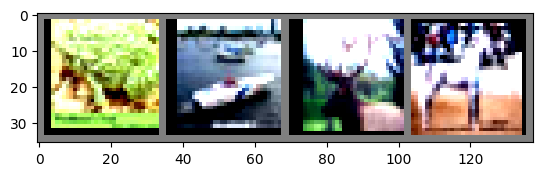

frog  ship  deer  horse


In [56]:
# getting some random training images
dataiter = iter(train_dl)
images, labels = next(dataiter)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


# show images
show_samples(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

## Building the network

In [57]:
model = ResNet18().to(device)
# sanity check
xx = torch.rand(1,3,32,32).to(device)
yy = model(xx)
yy.shape

torch.Size([1, 10])

In [58]:
summary(model, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

In [59]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

## Finding the LR

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.31E-04


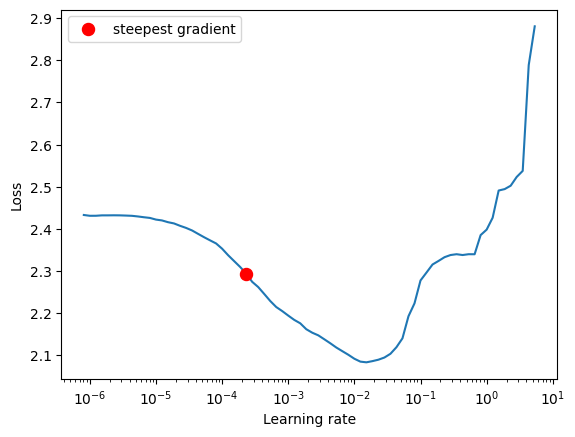

In [60]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-7)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_dl, end_lr=100, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

## Model Training

In [61]:
EPOCHS = 20

In [62]:
criterion = nn.CrossEntropyLoss()
criterion_test = nn.CrossEntropyLoss(reduction = 'sum')
optimizer = optim.Adam(model.parameters(), lr=1e-7)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, max_lr=1e-3, epochs=EPOCHS, steps_per_epoch=len(train_dl), pct_start=0.2, div_factor=10)

train_stats = {}
test_stats = {}
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train_epoch(model, device, train_dl, optimizer, criterion, epoch, train_stats)
    scheduler.step()
    test_epoch(model, device, test_dl, criterion_test, test_stats)


EPOCH: 0


Loss=1.3725885152816772 Batch_id=97 Accuracy=38.60: 100%|██████████| 98/98 [00:48<00:00,  2.01it/s]



Test set: Average loss: 1.4038, Accuracy: 5033/10000 (50.33%)

EPOCH: 1


Loss=1.1896498203277588 Batch_id=97 Accuracy=50.95: 100%|██████████| 98/98 [00:50<00:00,  1.95it/s]



Test set: Average loss: 1.3157, Accuracy: 5354/10000 (53.54%)

EPOCH: 2


Loss=1.117056965827942 Batch_id=97 Accuracy=57.45: 100%|██████████| 98/98 [00:49<00:00,  1.96it/s]



Test set: Average loss: 1.1731, Accuracy: 5933/10000 (59.33%)

EPOCH: 3


Loss=1.099518060684204 Batch_id=97 Accuracy=61.98: 100%|██████████| 98/98 [00:50<00:00,  1.94it/s]



Test set: Average loss: 0.9747, Accuracy: 6677/10000 (66.77%)

EPOCH: 4


Loss=0.8892812132835388 Batch_id=97 Accuracy=65.49: 100%|██████████| 98/98 [00:50<00:00,  1.95it/s]



Test set: Average loss: 0.8548, Accuracy: 6951/10000 (69.51%)

EPOCH: 5


Loss=0.8937041163444519 Batch_id=97 Accuracy=68.49: 100%|██████████| 98/98 [00:50<00:00,  1.95it/s]



Test set: Average loss: 0.9381, Accuracy: 6816/10000 (68.16%)

EPOCH: 6


Loss=0.8337892889976501 Batch_id=97 Accuracy=70.92: 100%|██████████| 98/98 [00:50<00:00,  1.96it/s]



Test set: Average loss: 0.7980, Accuracy: 7236/10000 (72.36%)

EPOCH: 7


Loss=0.7153245210647583 Batch_id=97 Accuracy=72.56: 100%|██████████| 98/98 [00:50<00:00,  1.96it/s]



Test set: Average loss: 0.7328, Accuracy: 7457/10000 (74.57%)

EPOCH: 8


Loss=0.7058424949645996 Batch_id=97 Accuracy=74.36: 100%|██████████| 98/98 [00:50<00:00,  1.95it/s]



Test set: Average loss: 0.6840, Accuracy: 7705/10000 (77.05%)

EPOCH: 9


Loss=0.6190414428710938 Batch_id=97 Accuracy=75.66: 100%|██████████| 98/98 [00:50<00:00,  1.96it/s]



Test set: Average loss: 0.6105, Accuracy: 7901/10000 (79.01%)

EPOCH: 10


Loss=0.6994563937187195 Batch_id=97 Accuracy=76.70: 100%|██████████| 98/98 [00:50<00:00,  1.95it/s]



Test set: Average loss: 0.6935, Accuracy: 7636/10000 (76.36%)

EPOCH: 11


Loss=0.6326024532318115 Batch_id=97 Accuracy=77.83: 100%|██████████| 98/98 [00:50<00:00,  1.95it/s]



Test set: Average loss: 0.6230, Accuracy: 7901/10000 (79.01%)

EPOCH: 12


Loss=0.650879442691803 Batch_id=97 Accuracy=79.03: 100%|██████████| 98/98 [00:50<00:00,  1.96it/s]



Test set: Average loss: 0.5346, Accuracy: 8158/10000 (81.58%)

EPOCH: 13


Loss=0.562589704990387 Batch_id=97 Accuracy=79.59: 100%|██████████| 98/98 [00:50<00:00,  1.95it/s]



Test set: Average loss: 0.5350, Accuracy: 8186/10000 (81.86%)

EPOCH: 14


Loss=0.5859185457229614 Batch_id=97 Accuracy=80.50: 100%|██████████| 98/98 [00:50<00:00,  1.95it/s]



Test set: Average loss: 0.5252, Accuracy: 8222/10000 (82.22%)

EPOCH: 15


Loss=0.5054177641868591 Batch_id=97 Accuracy=81.16: 100%|██████████| 98/98 [00:50<00:00,  1.95it/s]



Test set: Average loss: 0.5864, Accuracy: 8082/10000 (80.82%)

EPOCH: 16


Loss=0.46144208312034607 Batch_id=97 Accuracy=81.79: 100%|██████████| 98/98 [00:50<00:00,  1.95it/s]



Test set: Average loss: 0.5603, Accuracy: 8134/10000 (81.34%)

EPOCH: 17


Loss=0.4573773741722107 Batch_id=97 Accuracy=82.34: 100%|██████████| 98/98 [00:50<00:00,  1.95it/s]



Test set: Average loss: 0.4735, Accuracy: 8408/10000 (84.08%)

EPOCH: 18


Loss=0.47240403294563293 Batch_id=97 Accuracy=82.91: 100%|██████████| 98/98 [00:49<00:00,  1.96it/s]



Test set: Average loss: 0.5226, Accuracy: 8265/10000 (82.65%)

EPOCH: 19


Loss=0.40510132908821106 Batch_id=97 Accuracy=83.52: 100%|██████████| 98/98 [00:50<00:00,  1.96it/s]



Test set: Average loss: 0.4970, Accuracy: 8370/10000 (83.70%)



## Train & Test Accuracy

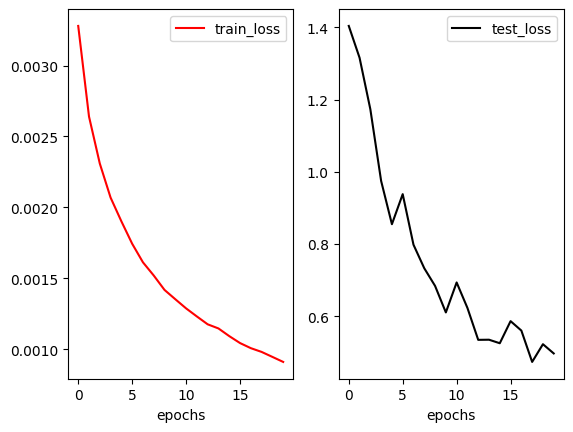

In [63]:
plot_loss(train_stats, test_stats)

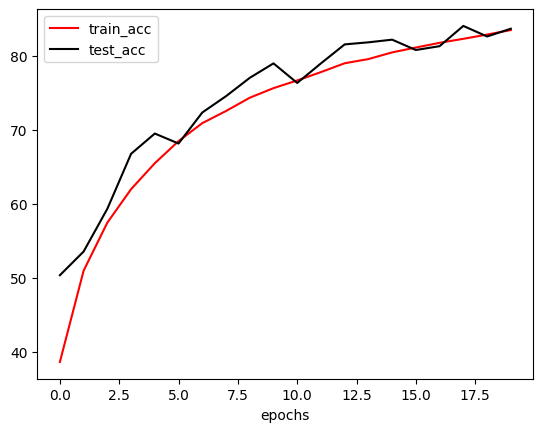

In [64]:
plot_acc(train_stats, test_stats)

## Mis-classified images

In [70]:
misclassified = {}
get_misclassified(model, device, test_dl, misclassified, num_samples=10)

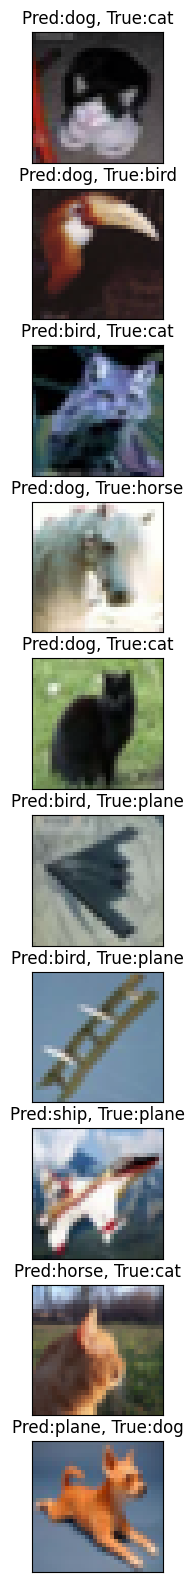

In [66]:
show_misclassified_imgs(misclassified, classes, nmax=10)

## Grad-CAM

(10, 32, 32)


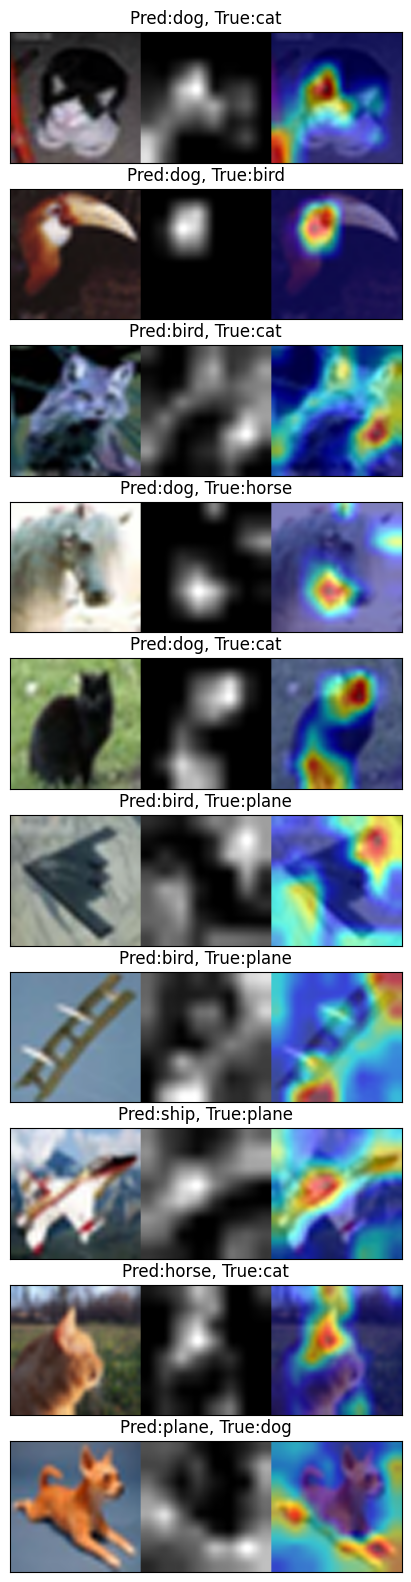

In [67]:
input_tensor = misclassified['data']
original_imgs = get_denormalized_imgs(input_tensor)
wrong_preds = misclassified['pred']
correct_labels = misclassified['target']
target_layers = [model.layer3[-1]]
grayscale_cams, cam_image = get_gradcam_img(model, target_layers, input_tensor, original_imgs, wrong_preds)
show_gradcam_plots(grayscale_cams, cam_image, original_imgs, classes, \
                       wrong_preds, correct_labels, resize=(1024,1024), figsize=(20,20))